# NLP 
### Analýza dramatu R.U.R. od Karla Čapka - porovnání české a anglické verze


In [1055]:
import pandas as pd
import numpy as np
import random
import io
import os
import re
import string

import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#nltk.download()
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

import re
import pandas as pd
import numpy as np
from time import time
from collections import defaultdict
from gensim.models import Word2Vec
import random
import seaborn as sns

## Načtení textů z webu

In [1056]:
import requests
page_cz = requests.get("https://www.gutenberg.org/files/13083/13083-0.txt")
page_en = requests.get('http://www.gutenberg.org/files/59112/59112-h/59112-h.htm')

In [1057]:
from bs4 import BeautifulSoup
soup1 = BeautifulSoup(page_cz.content)
soup2 = BeautifulSoup(page_en.content, 'html.parser')

## Předzpracování české verze

In [1101]:
text_cz = str(soup1)  #načtení textu

info = text_cz[:2018]
text_cz = text_cz[2018:-19041]
#text_cz = re.sub(r"\([^()]*\)", "", text_cz)  
text_cz = re.sub("[\(\[].*?[\)\]]", "", text_cz) #odstranění textu v závorkách komentujícího situaci/stav
text_cz = text_cz.replace('--', ' ')

In [1131]:
text_cz[:500]

'Předehra\r\n\r\n\r\n\r\nÚstřední kancelář továrny Rossum s Universal Robots. Vpravo vchod. Okny\r\nv průčelní stěně pohled na nekonečné řady továrních budov. Vlevo další\r\nředitelské místnosti.\r\n\r\nDomin: (sedí u velikého amerického psacího stolu v otáčecím křesle. Na\r\n    stole žárovka, telefon, těžítka, pořadač dopisů, atd., na stěně vlevo\r\n    veliké mapy s lodními a železničními liniemi, veliký kalendář, hodiny,\r\n    jež ukazují něco málo před polednem; na stěně vpravo tištěné plakáty:\r\n    "Nejlacinějš'

In [1103]:
# extrakce konverzací z textu, příprava na tvorbu dataframu

text_s = text_cz.split("\r\n\r\n")  

to_be_df = []
for i in text_s:
    i = re.sub("[\r\n ]+", ' ', str(i)).lower()
    to_be_df.append(i.split(":"))
    
cut = []
for i in to_be_df:
    if len(i)==2:
        cut.append(i)
        
cut[:4]

[['domin',
  ' " že neručíme za zboží poškozené dopravou. upozornili jsme vašeho kapitána hned při nakládání, že loď je nezpůsobilá k dopravě robotů, takže zkáza nákladu nepadá na náš účet. znamenáme se za rossum s universal robots " hotovo?'],
 ['sulla', ' ano.'],
 ['domin',
  ' nový list. friedrichswerke, hamburk. datum. "potvrzujeme objednávku patnáct tisíc robotů " (zazvoní domácí telefon. domin jej zvedne a mluví do něho) haló zde centrální ano. zajisté. ale ano, jako vždycky. ovšem, kabelujte jim. dobrá kde jsem přestal?'],
 ['sulla', ' potvrzujeme objednávku na patnáct tisíc r.']]

In [1104]:
df1 = pd.DataFrame(cut,columns=['character','line'])
df1.head()

character                                               line
0     domin   " že neručíme za zboží poškozené dopravou. up...
1     sulla                                               ano.
2     domin   nový list. friedrichswerke, hamburk. datum. "...
3     sulla         potvrzujeme objednávku na patnáct tisíc r.
4     domin                  patnáct tisíc r. patnáct tisíc r.

In [1105]:
df1.isnull().sum()

character    0
line         0
dtype: int64

In [1107]:
# zachování charakterů s více jak 1 větou 
df1 = df1[df1['character'].map(df1['character'].value_counts()) > 1]
df1.groupby('character').count()

line
character           
2. robot           4
3. robot          10
4. robot           7
alquist          149
busman            74
damon             13
domin            328
dr. gall         131
fabry             86
hallemeier        91
helena           450
hlas alquistův     4
hlas damonův       2
hlas vpravo        2
jiný robot         2
křik damonův       6
marius             8
nána              46
primus            43
radius            30
robot              3
sluha              4
sulla             14

## Předzpracování anglické verze

In [1124]:
#en verze má trochu jiné formátování -> odlišné zpracování
text_en = soup2.text

chars = text_en[6761:7553]
text_en = text_en[8642:-24878]
text_en = re.sub("[\(\[].*?[\)\]]", "", text_en)
text_en = re.sub(r"\([^()]*\)", "", text_en)  

text_en = text_en.replace('Dr. Gall', 'Dr Gall').lower() # abychom se vyhnuli pozdějšímu dělení větu u prvního výskytu tečky

In [1138]:
text_en[:500]

'act one\n\n\nscene: central office of the factory of rossum’s\r\nuniversal robots. entrance r. down right. the\r\nwindows on the back wall look out on the endless\r\nroads of factory buildings. door l. down\r\nleft. on the left wall large maps showing\r\nsteamship and railroad routes. on the right\r\nwall are fastened printed placards.  in contrast to these wall\r\nfittings, the floor is covered with splendid turkish\r\ncarpet, a couch r.c. a book shelf containing\r\nbottles of wine and spirits, instead of books.\n\nd'

In [1139]:
text_l = [x for x in text_en.replace('\r\n', '').split('\n')]
text_split = [x.split('.', 1) for x in text_l]

In [1140]:
df2 = DataFrame(text_split,columns=['character','line'])
df2 = df2.dropna()

df2 = df2[df2['character'].map(df2['character'].value_counts()) > 1]
df2.head()

character                                               line
9      domin                                             ready?
10     sulla                                               yes.
11     domin   to e. m. mcvicker & co., southampton,england....
12     sulla                                               yes.
13     domin   another letter. to the e. b. huysenagency, ne...

In [1171]:
df2.groupby('character').count()

line
character       
1st robot      6
2nd robot      2
alquist       83
busman        69
domin        324
dr gall      100
fabry         78
hallemeier    76
helena       389
marius         8
nana          42
primus        24
radius        33
robot          2
servant        2
sulla         17

In [1169]:
df2.loc[(df2['character'] == "r") | (df2['character'] == "l")]

character                                               line
461          l  2 door to the outside is a writing desk. there...
468          r                                                   
704          r   radius follows. helena gets a needle from wor...
929          r   domin comes into the room, l.2.  dr gall is l...
1267         l  ) no time—so little done.  what do youwant? be...

In [1170]:
df2 = df2.loc[(df2['character'] != "r") & (df2['character'] != "l")]

In [1164]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

## Nejukecanější postavy
### - zobrazení aktivity postav v dialozích pomocí wordcloudu
#### - teoreticky by to mělo vyjít podobně pro cz i en verzi

In [1176]:
names_cz = " ".join(df1.character)
names_en = " ".join(df2.character)

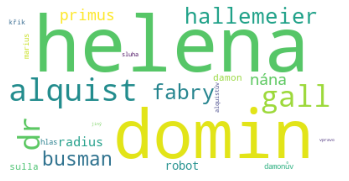

In [1177]:
# česká verze
wordcloud = WordCloud(background_color="white", 
                      collocations = False,
                     ).generate(names_cz)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

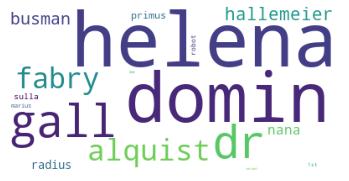

In [1178]:
#en verze
wordcloud = WordCloud(background_color="white", 
                      collocations = False,
                     ).generate(names_en)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Tvorba korpusu 
### Stopwords, lematizace, čištění 

In [1179]:
import simplemma
langdata = simplemma.load_data('cs')

from stop_words import get_stop_words
stop_words = get_stop_words('cz')
stop_words.append("jako")
stop_words.append("a")

In [1212]:
# simplelemma lemmatizace není u češtiny úplně vychytaná
for t in df1.line[5].split():
    print(t, "->" ,simplemma.lemmatize(t, langdata))

pane -> pan
řediteli, -> řediteli,
nějaká -> nějaký
dáma -> dáma
prosí -> prosit


In [1266]:
#půjčeno z přednášky s drobnou modifikací
lemmatizer = simplemma

def processSentenceCZ(sentence, y):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    for i in sentence.split():
        if i.startswith("robo"):
            sentence = sentence.replace(str(i) , "robot" )    #extra lemmatizace slova robot
    ww = sentence.split()
    ww = [x for x in ww if x not in stop_words]
    ww = [x for x in ww if len(x) > 1]
    ww = [lemmatizer.lemmatize(x, y) for x in ww]
    if len(ww)>2:
        return " ".join(ww)
    else:
        return np.nan
    
cleaned1 = [processSentenceCZ(x, langdata) for x in df1.line]

df1["cleaned_line"] = [processSentenceCZ(x, langdata) for x in df1.line]
df1 = df1.dropna()

In [1267]:
df1.head()

character                                               line  \
0      domin   " že neručíme za zboží poškozené dopravou. up...   
2      domin   nový list. friedrichswerke, hamburk. datum. "...   
5     marius                  pane řediteli, nějaká dáma prosí    
7     marius                             nevím. podává vizitku.   
11    helena                       pan centrální ředitel domin?   

                                         cleaned_line  
0   neručíme zbožit poškozený dopravou upozornit t...  
2   nový list friedrichswerke hamburk datum potvrz...  
5                      pan ředitel nějaký dáma prosit  
7                               vědět podávat vizitku  
11                        pan centrální ředitel domin

In [1268]:
df2.line = [re.sub("[^A-Za-z']+", ' ', str(row)) for row in df2['line']]
df2.line= [re.sub("[/']", '', str(row)) for row in df2.line]

In [1277]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def processSentenceEN(sentence):
    ww = sentence.split()
    #ww = nltk.word_tokenize(sentence)
    ww = [x for x in ww if x not in stopwords]
    ww = [lemmatizer.lemmatize(x) for x in ww]
    ww = [x for x in ww if len(x) > 1]
    if len(ww)>2:
        return " ".join(ww)
    else:
        return np.nan
    
cleaned2 = [processSentenceEN(x) for x in df2.line]

df2["cleaned_line"] = [processSentenceEN(x) for x in df2.line]
df2 = df2.dropna()

In [1278]:
df2.head()

character                                               line  \
11     domin   to e m mcvicker co southampton england we und...   
13     domin   another letter to the e b huysenagency new yo...   
15     domin   hello yes no all right another letter freidri...   
16    marius              there s a lady sir asking to see you    
18    marius   i don t know sir she brings this cardof intro...   

                                         cleaned_line  
11  mcvicker co southampton england undertake guar...  
13  another letter huysenagency new york beg ackno...  
15  hello yes right another letter freidrichswerks...  
16                                lady sir asking see  
18                know sir brings cardof introduction

### Korpus ze všech dialogů

In [1279]:
corpus_cz = " ".join(df1["cleaned_line"])
corpus_en = " ".join(df2["cleaned_line"])

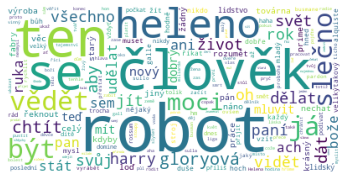

In [1280]:
# výskyt slov podle četnosti - cz 
wordcloud = WordCloud(background_color="white", 
                      collocations = False,
                     ).generate(corpus_cz)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

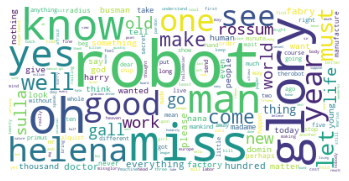

In [1281]:
# výskyt slov podle četnosti - en
wordcloud = WordCloud(background_color="white", 
                      collocations = False,
                     ).generate(corpus_en)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [1283]:
#tokenizace slov
words1 = nltk.word_tokenize(corpus_cz)
words2 = nltk.word_tokenize(corpus_en)

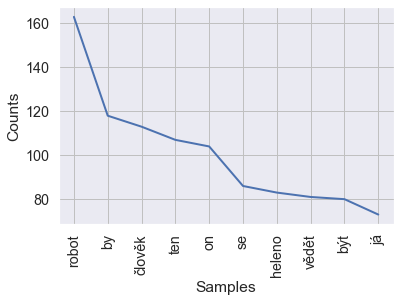

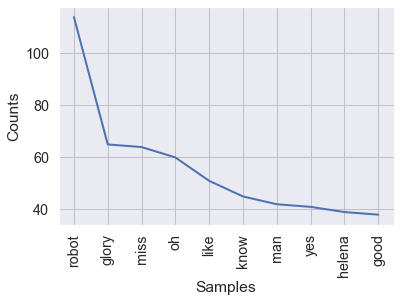

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [1284]:
# četnost tokenů - robot v obou případech top slovo, člověk (man/human) už odlišně vyhodnoceno
freq = nltk.FreqDist(words1)
freq2 = nltk.FreqDist(words2)
freq.plot(10, cumulative=False)
freq2.plot(10, cumulative=False)

In [1285]:
dfs = [df1, df2]
def top3(df):
    freq = nltk.FreqDist(df.character)
    freq.most_common(3)
    for char in freq.most_common(3):
        print(char[0])

for df in dfs:
    print(top3(df))

helena
domin
alquist
None
domin
helena
fabry
None


In [1286]:
chars = ["helena", "domin", "alquist", "fabry"]
for char in chars:
    print(char)

helena
domin
alquist
fabry


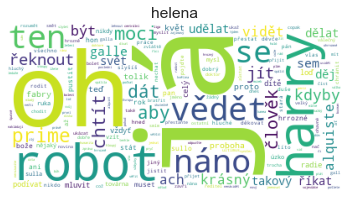

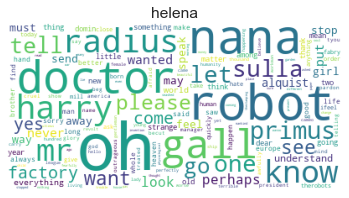

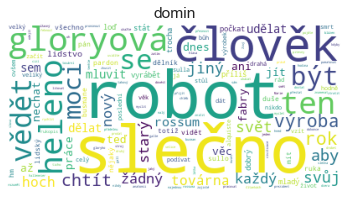

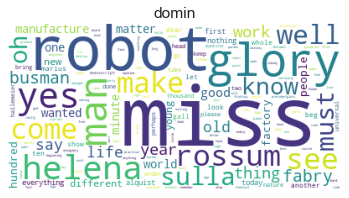

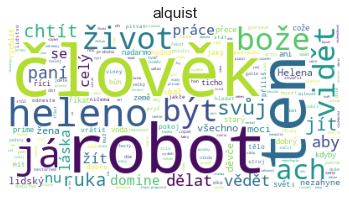

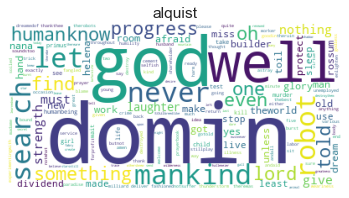

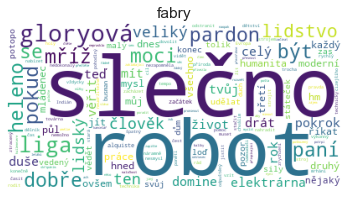

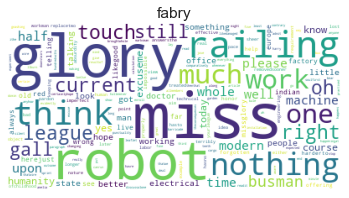

In [1459]:
#odlišnosti v nejvíce používaných slovech jednotlivých postav a překladech

for char in chars:
    for df in dfs:
        char_text = " ".join(df[df["character"]==char]["cleaned_line"])
        wordcloud = WordCloud(background_color="white", 
                              collocations = False,
                             ).generate(char_text)

        plt.imshow(wordcloud)
        plt.title(char)
        plt.axis("off")
        plt.show()
        

## Operace s vektory

### Tokenizace

In [1308]:
temp1 = [x for x in df1['cleaned_line']]
tokens_cz = [x.split() for x in temp1]
temp2 = [x for x in df2['cleaned_line']]
tokens_en = [x.split() for x in temp2]

In [1447]:
model_cz = Word2Vec(tokens_cz, min_count = 1)
words_cz = list(model_cz.wv.vocab)

model_en = Word2Vec(tokens_en, min_count = 1)
words_en = list(model_en.wv.vocab)

In [1518]:
model_cz.wv.most_similar(positive=['robot'])

[('být', 0.8699582815170288),
 ('se', 0.8463483452796936),
 ('hodně', 0.8439222574234009),
 ('ten', 0.8331255316734314),
 ('člověk', 0.8248200416564941),
 ('láska', 0.8100916147232056),
 ('tolik', 0.8028330206871033),
 ('vědět', 0.8021611571311951),
 ('on', 0.801850438117981),
 ('kdyby', 0.7973009347915649)]

In [1519]:
model_en.wv.most_similar(positive=['robot'])

[('put', 0.2935190796852112),
 ('please', 0.2723715305328369),
 ('god', 0.24651674926280975),
 ('hand', 0.21083253622055054),
 ('time', 0.20708012580871582),
 ('without', 0.2039780616760254),
 ('never', 0.19721321761608124),
 ('first', 0.19113373756408691),
 ('hundred', 0.18633422255516052),
 ('helena', 0.18313691020011902)]

In [1314]:
model_cz.similarity('robot', 'člověk')

0.39367962

In [1324]:
model_en.similarity('robot', 'human')

0.08261935

In [1346]:
model_cz.wv.doesnt_match(["robot", "člověk", "bůh"])

'bůh'

In [1461]:
model_en.wv.doesnt_match(["robot", "human", "god"])

'human'

In [1543]:
model_cz.most_similar(positive=['stroj', 'být'], negative=['člověk'], topn=5)

[('robot', 0.734097957611084),
 ('on', 0.7253949046134949),
 ('ten', 0.7184512615203857),
 ('hodně', 0.7003791332244873),
 ('se', 0.6957709789276123)]

In [1544]:
model_en.most_similar(positive=['helena', 'primus'], negative=['human'], topn=5)

[('machine', 0.30193644762039185),
 ('life', 0.26144933700561523),
 ('show', 0.22222404181957245),
 ('nothing', 0.20470626652240753),
 ('mill', 0.1966032087802887)]

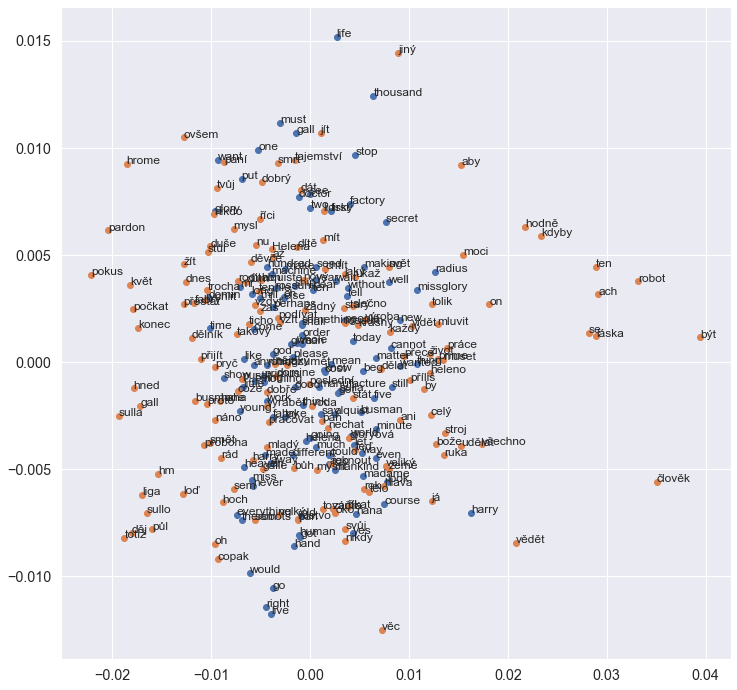

In [1455]:
#PCA overlay
model_en = Word2Vec(tokens_en, min_count = 9)
words_en = list(model_en.wv.vocab)
X = model_en[model_en.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(12, 12))
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words_en):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=12)

model_cz = Word2Vec(tokens_cz, min_count = 9)
words_cz = list(model_cz.wv.vocab)
X = model_cz[model_cz.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)   

plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words_cz):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=12)

## Analýza sentimentu

### pouze v angličtině

In [1348]:
from afinn import Afinn
af = Afinn(language="en")

In [1349]:
sentiment_scores = [af.score(line) for line in df2["line"]]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

In [1350]:
df = pd.DataFrame([list(df2["character"]), list(df2["line"]), sentiment_scores, sentiment_category]).T
df.columns = ["character", 'sentence', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.head()

character                                           sentence  \
0     domin   to e m mcvicker co southampton england we und...   
1     domin   another letter to the e b huysenagency new yo...   
2     domin   hello yes no all right another letter freidri...   
3    marius              there s a lady sir asking to see you    
4    marius   i don t know sir she brings this cardof intro...   

   sentiment_score sentiment_category  
0             -2.0           negative  
1              4.0           positive  
2              0.0            neutral  
3              0.0            neutral  
4              0.0            neutral

In [1360]:
# Nejvíc pozitivní a negativní věty
print(df.sentence[(df['sentiment_score'] == df.sentiment_score.max())], df.sentence[(df['sentiment_score'] == df.sentiment_score.min())])
#df[df.sentiment_score == df.sentiment_score.max()]["sentence"]

433     if the timetable holds good human laws hold g...
Name: sentence, dtype: object 324     he shouldn t make them the robot soldiers spa...
Name: sentence, dtype: object


In [1361]:
dff = df[['character', 'sentiment_score']].groupby(['character'], as_index=False).sum().sort_values(ascending=False, by = "sentiment_score")

dff['sentiment'] = "positive"
dff.loc[dff['sentiment_score'] < 0, 'sentiment'] = "negative"
dff.loc[dff['sentiment_score'] == 0, 'sentiment'] = "neutral"

dff    

character  sentiment_score sentiment
7   hallemeier             83.0  positive
4        domin             82.0  positive
3       busman             48.0  positive
14       sulla             11.0  positive
8       helena             10.0  positive
12      radius              8.0  positive
6        fabry              6.0  positive
0    1st robot              1.0  positive
9       marius              1.0  positive
13     servant              0.0   neutral
11      primus             -1.0  negative
1    2nd robot             -3.0  negative
2      alquist             -8.0  negative
5      dr gall            -18.0  negative
10        nana            -21.0  negative

[Text(0, 0, 'hallemeier'),
 Text(1, 0, 'domin'),
 Text(2, 0, 'busman'),
 Text(3, 0, 'sulla'),
 Text(4, 0, 'helena'),
 Text(5, 0, 'radius'),
 Text(6, 0, 'fabry'),
 Text(7, 0, '1st robot'),
 Text(8, 0, 'marius'),
 Text(9, 0, 'servant'),
 Text(10, 0, 'primus'),
 Text(11, 0, '2nd robot'),
 Text(12, 0, 'alquist'),
 Text(13, 0, 'dr gall'),
 Text(14, 0, 'nana')]

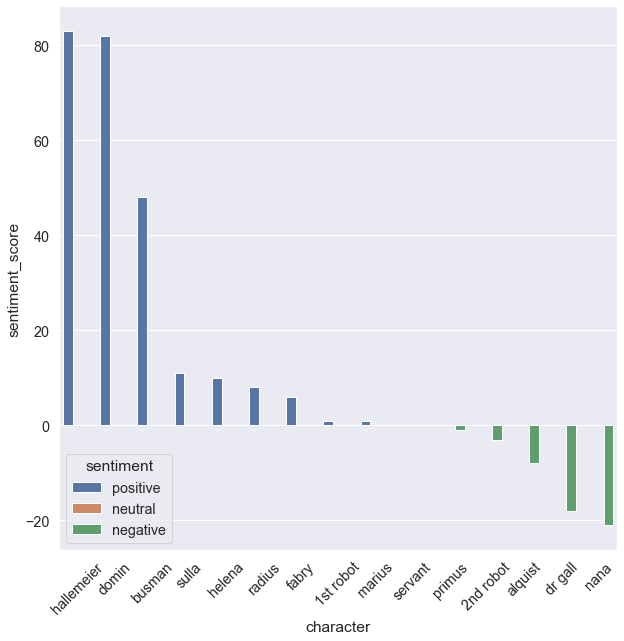

In [1362]:
#Dobré a zlé charaktery 

plt.figure(figsize=(10,10))
fig = sns.barplot(x="character", y="sentiment_score", data=dff, hue = "sentiment")
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)

